Import all libraries and load data

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import jaccard_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.base import clone
from ast import literal_eval
from collections import Counter
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import chain, combinations
import itertools

In [2]:
dataset = (pd.read_csv('data/train.csv'))

Split data into train and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns='price_range'), dataset['price_range'], test_size=0.1, random_state=42)
y_true = y_test.copy()


### T-SNE visualization

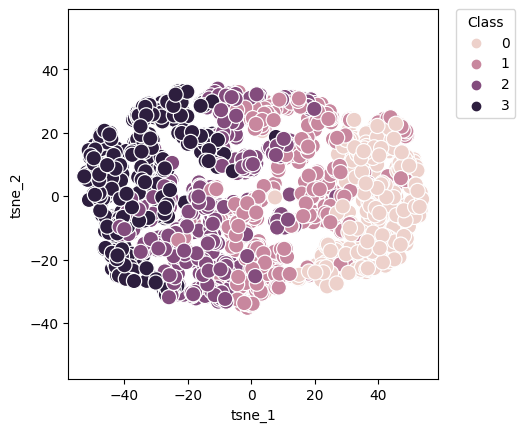

In [9]:
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X_train)
tsne_result.shape
y_true = np.reshape(y_true, (y_true.shape[0],))

y_tsne = np.reshape(y_train, (y_train.shape[0],))
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_tsne})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title = 'Class')
plt.show()

### Class of classifier chain

In [5]:
class ClassifierChain():
  # Making classifier chain
  def __init__(self,classifiers):
    self.classifiers = classifiers
  
  def train(self, X_train, y_train):
    for i, clf in enumerate(self.classifiers):
      # Fitting classifier to labels
      clf.fit(X_train, y_train[-1800:])
      # Updating labels with previous classifier's predictions 
      y_train = np.hstack([y_train, clf.predict(X_train)])
      

  def predict(self, X_test, y_test):
    y_pred = np.zeros((len(X_test), len(classifiers)))
    for i, clf in enumerate(classifiers):
      y_pred[:, i] = clf.predict(X_test)
      # Updating labels with previous classifier's predictions
      y_test = np.hstack([y_test, y_pred[:, i]])
    # Taking the mean of all results
    y_pred = y_pred.mean(axis=1)
    y_pred = y_pred[:, np.newaxis]
    y_pred = [int(np.round(val)) for val in y_pred]
    return y_pred

Sample usage of chain

In [6]:
classifiers = [KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier()]
chain = ClassifierChain(classifiers)
X_test_copy = X_test.copy()
X_train_copy = X_train.copy()
y_test_copy = y_test.copy()
y_train_copy = y_train.copy()
chain.train(X_train_copy, y_train_copy)
y_pred = chain.predict(X_test_copy, y_test_copy)
# Wyświetlenie dokładności klasyfikacji
mse = mean_squared_error(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)
print(f"Chain: {classifiers}")
print(f"Mean squared error: {mse:.2f}")
print(f"F1 metric value: {f1:.2f}")
print(f"Accuracy: {acc:.2f}\n")

Chain: [KNeighborsClassifier(), DecisionTreeClassifier()]
Mean squared error: 0.12
F1 metric value: 0.88
Accuracy: 0.88



### Now I will match classifiers into pairs and check all combinations to find the best one

In [7]:
def all_pairs(classifiers):
    return [(a, b) for idx, a in enumerate(classifiers) for b in classifiers[idx + 1:]]

def all_threes(classifiers):
  subsets = []
  for clf1 in classifiers:
    for clf2 in classifiers:
      for clf3 in classifiers:
        subsets.append([clf1,clf2,clf3])
  return subsets

# Define some classifiers
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier()
logreg = LogisticRegression(max_iter=len(y_train), solver = 'liblinear')
svm = SVC()
mlp = MLPClassifier(alpha=1, max_iter=1000)
ada = AdaBoostClassifier()
nb = GaussianNB()
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
lda = LinearDiscriminantAnalysis()
experiments = []




classifiers_types = [knn,tree,svm,logreg, mlp,ada,nb,random_forest,lda]
pairs = True

if pairs:
  df = pd.DataFrame(columns=('chain1','chain2','mse','f1','acc','time'))
  for subset in all_pairs(classifiers_types):
      experiments.append(subset)
else:
  df = pd.DataFrame(columns=('chain1','chain2','chain3','mse','f1','acc','time'))
  experiments = all_threes(classifiers_types)

In [8]:
for classifiers in experiments:

  #Clean classifiers
  for clf in classifiers:
    clf = clone(clf)
  #Reset data to its original form
  X_test_copy = X_test.copy()
  X_train_copy = X_train.copy()
  y_test_copy = y_test.copy()
  y_train_copy = y_train.copy()

  chain = ClassifierChain(classifiers)
  train_start = time.time()
  chain.train(X_train_copy, y_train_copy)
  train_end = time.time()
  y_pred  = chain.predict(X_test_copy, y_test_copy)

  mse = mean_squared_error(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='weighted')
  acc = accuracy_score(y_true, y_pred)
  t = (train_end-train_start)
  if pairs:
    new_row = {'chain1': classifiers[0],'chain2': classifiers[1], 'mse':mse, 'f1':f1,'acc':acc,'time':t}
  else:
    new_row = {'chain1': classifiers[0],'chain2': classifiers[1], 'chain3': classifiers[2],'mse':mse, 'f1':f1,'acc':acc,'time':t}
  df.loc[len(df)] = new_row

df.sort_values(ascending=False, by='f1')

,chain1,chain2,mse,f1,acc,time
20,SVC(),LinearDiscriminantAnalysis(),0.045,0.955152,0.955,0.104460
1,KNeighborsClassifier(),SVC(),0.055,0.944987,0.945,0.177536
7,KNeighborsClassifier(),LinearDiscriminantAnalysis(),0.060,0.940283,0.940,0.070810
8,DecisionTreeClassifier(),SVC(),0.070,0.930211,0.930,0.143617
19,SVC(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.080,0.919598,0.920,0.416882
17,SVC(),"(DecisionTreeClassifier(max_depth=1, random_st...",0.090,0.910088,0.910,0.224369
14,DecisionTreeClassifier(),LinearDiscriminantAnalysis(),0.095,0.905855,0.905,0.018041
35,"(DecisionTreeClassifier(max_features='sqrt', r...",LinearDiscriminantAnalysis(),0.100,0.900981,0.900,0.321066
6,KNeighborsClassifier(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.100,0.899740,0.900,0.397933
0,KNeighborsClassifier(),DecisionTreeClassifier(),0.110,0.889295,0.890,0.067095


In [10]:
metrics = ['f1','acc','time','mse']
results = pd.DataFrame(columns=['type','any','first','second'])
metric = metrics[0]
for searched_clf in classifiers_types:
  any = float(df[(df.chain1 == searched_clf) | (df.chain2 == searched_clf) ] [[metric]].max())
  first = float(df[(df.chain1 == searched_clf)] [[metric]].max())
  second = float(df[ (df.chain2 == searched_clf) ] [[metric]].max())
  new_row = {'type':searched_clf,'any':any,'first':first,'second':second}
  results.loc[len(results)] = new_row
results

C:\Users\Kubi\AppData\Local\Temp\ipykernel_7604\2439275161.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  any = float(df[(df.chain1 == searched_clf) | (df.chain2 == searched_clf) ] [[metric]].max())
C:\Users\Kubi\AppData\Local\Temp\ipykernel_7604\2439275161.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first = float(df[(df.chain1 == searched_clf)] [[metric]].max())
C:\Users\Kubi\AppData\Local\Temp\ipykernel_7604\2439275161.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  second = float(df[ (df.chain2 == searched_clf) ] [[metric]].max())
C:\Users\Kubi\AppData\Local\Temp\ipykernel_7604\2439275161.py:5: FutureWarning: Calling float on a single element Series is deprecated and will ra

,type,any,first,second
0,KNeighborsClassifier(),0.944987,0.944987,NaN
1,DecisionTreeClassifier(),0.930211,0.930211,0.889295
2,SVC(),0.955152,0.955152,0.944987
3,"LogisticRegression(max_iter=1800, solver='libl...",0.865365,0.799751,0.865365
4,"MLPClassifier(alpha=1, max_iter=1000)",0.847321,0.720075,0.847321
5,"(DecisionTreeClassifier(max_depth=1, random_st...",0.910088,0.725009,0.910088
6,GaussianNB(),0.865007,0.825893,0.865007
7,"(DecisionTreeClassifier(max_features='sqrt', r...",0.919598,0.900981,0.919598
8,LinearDiscriminantAnalysis(),0.955152,NaN,0.955152


Here, you can see which classifier works best on which place in chain and what F! value it is achieving